<a href="https://colab.research.google.com/github/Shanty-01/HandwrittenDigits-Recognizer/blob/main/HandwrittenDigits_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
This project aims to evaluate different benchmark models on MNIST dataset to determine the best approach for handwritten digit classification.
# About

*   Evaluation is based on the training time and accuracy.
*   The models Support-vector machine (SVM) and K-Nearest Neighbors (KNN) are chosen for their strong baseline performance in classification tasks.
* And while Convolutional neural network (CNN) is more suited to image data dan simple multi-layer perceptron (MLP), an MLP model is also evaluated to see the extent of its capability in image classification.
* The Modified National Institute of Standards and Technology(MNIST) dataset is a publicly available handwritten digits images from NIST. This project accesses the dataset from google colab sample_data folder :  '/content/sample_data/mnist_test.csv' and '/content/sample_data/mnist_train_small.csv'
* The best model is evaluated on newly photographed handwritten digits.



# Imports

In [ ]:
import time
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from tqdm.auto import tqdm
import copy
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load and Display Data

In [ ]:
# Load Data
X_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
X_test = pd.read_csv('/content/sample_data/mnist_test.csv')

In [ ]:
# The '6' column in the training set is the class label,
# while it's '7' for the test set. Count each class.
count_train = X_train['6'].value_counts(sort=True)
count_test = X_test['7'].value_counts(sort=True)

Text(0.5, 1.0, 'Number of Test Samples')

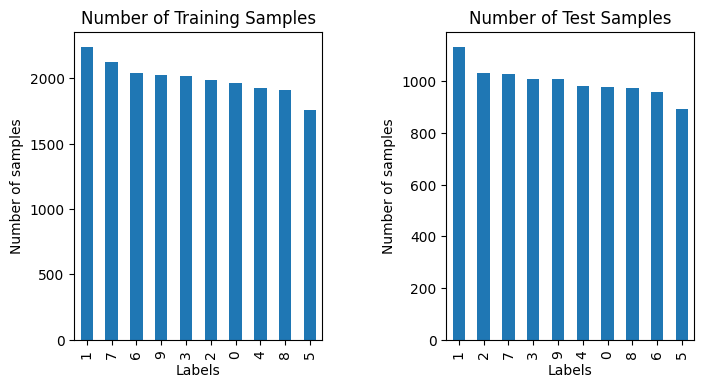

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)
count_train.plot(kind='bar',ax=axes[0], xlabel='Labels',ylabel='Number of samples')
axes[0].set_title('Number of Training Samples')
count_test.plot(kind='bar',ax=axes[1],xlabel='Labels',ylabel='Number of samples')
axes[1].set_title('Number of Test Samples')

In [ ]:
# Seperate the labels to y variabels
y_train = X_train.pop('6')
y_test = X_test.pop('7')

In [ ]:
# normalize to 0-1
X_train = X_train.to_numpy() / 255.0
X_test = X_test.to_numpy() / 255.0
y_train = y_train.to_numpy()
y_test =  y_test.to_numpy()

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((19999, 784), (9999, 784), (19999,), (9999,))

In [ ]:
# Reshape to visualize in its original resolution : 28 x 28
X_train_img = X_train.reshape(-1,28,28)
X_test_img = X_test.reshape(-1,28,28)

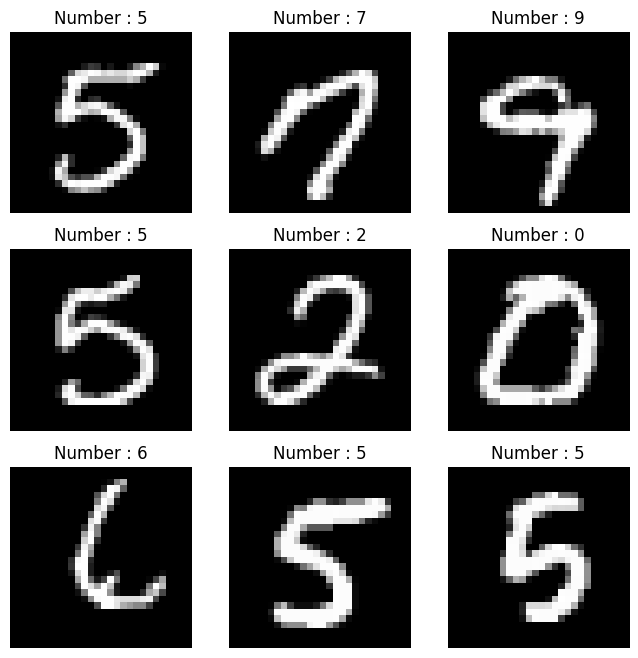

In [ ]:
row = 3
col = 3
fig, axes = plt.subplots(row,col,figsize=(8,8))
axes = axes.flatten()
for i in range(row*col):
  image = X_train_img[i]
  title = y_train[i]
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f'Number : {title}')
  axes[i].axis('off')

# Support Vector Machines(SVM)
## What is SVM?
Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. The goal of SVM is to find a hyperplane that best separates the data points into different classes.

## How does it work?

### 1. Finding the Hyperplane
A hyperplane is a decision boundary that separates the data points. For 2D data, it's a line, and for 3D data, it's a plane. The best hyperplane is the one that maximizes the margin, which is the distance between the hyperplane and the nearest data points (support vectors) from either class.  
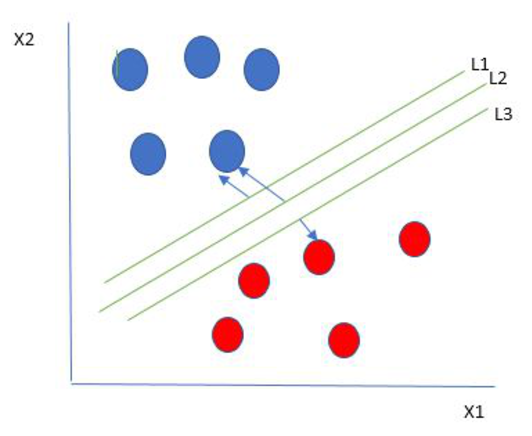
### 2. The Objective Function
The hyperline can be written as :  
$w^T \cdot x_i + b$  
Where:
- $w$ : Weight vector defining the hyperplane.
- $b$ : Bias term.
- $x_i$ : Feature vector of the \(i\)-th data point.<br><br>

The distance between a data point $x_i$ and the hyperline is given as:  
$d_i = \frac{w^T \cdot x_i + b}{||w||}$<br><br>
SVM optimizes the following objective:  
$
\min \frac{1}{2} ||w||^2 \quad \text{subject to } y_i (w \cdot x_i + b) \geq 1 \quad \forall i
$  
Where $y_i$ is a class label of the \(i\)-th data point $(+1$ or $-1$).<br><br>

### 3. Dealing with Non-linearly Separable Data
For cases where the data is not linearly separable, SVM uses:
- **Kernel functions** to map data into a higher-dimensional space.
- **Soft margin** (adding slack variables) to allow some misclassification.

Common kernels:
- Linear
- Polynomial
- Radial Basis Function (RBF)

In [ ]:
svm_model = SVC(kernel='rbf')
start_time = time.time()
svm_model.fit(X_train,y_train)
end_time = time.time()
svm_time = end_time - start_time

In [ ]:
svm_time

50.75989294052124

In [ ]:
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.96999699969997
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.96      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.96      1027
           8       0.97      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999



## What's in a classification report ?
The classification report provides detailed metrics of how the model performs on each class(0-9) in the dataset.  
The metrics are:  
1. Precision  
Measures how much of the predicted positive samples are correctly predicted.  
$\text{Precision} = \frac{True Positives}{True Positives+False Positives}$
2. Recall  
Measures how much of the actual positive samples are correctly identified.  
$\text{Recall} = \frac{True Positives}{True Positives+False Negatives}$
3. F1-score  
Harmonic mean of precision and recall, to balance the two metrics.  
$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$
4. Support  
The number of data in a certain class available in the test set
5. Accuracy  
The fraction of total predictions that are correct.  
$\text{Accuracy} = \frac{\text{Number of Correct Predictions
}}{\text{Total Predictions}}
$
6. Macro Average  
Calculates the average of each metric (precision, recall, F1-score) across all classes equally, regardless of the class size.  
7. Weighted Average  
Calculates the average of each metric, but it weights each class by its support (number of samples in the class).

In [ ]:
def conf_matr(y_true, y_pred, labels):
  cm = confusion_matrix(y_true,y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

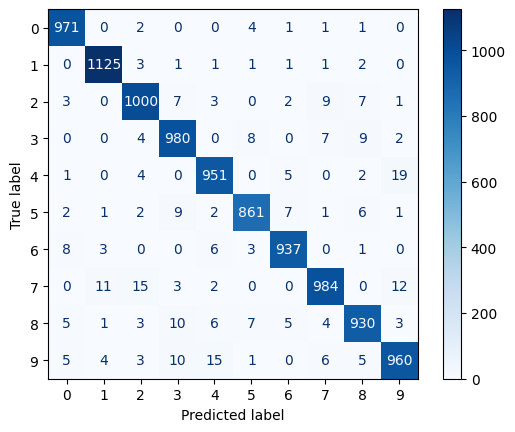

In [ ]:
conf_matr(y_test, y_pred, labels=svm_model.classes_)

## What's in a confusion matrix?
The confusion matrix compares the predicted labels with the actual labels for a classification problem.  
* The rows represent the actual class.
* The columns represent the predicted class.  

Not only we could get the count of true positives, but we can also identify which classes contribute to the false positives for a particular class, which can help in error analysis.

We could see that the highest number of false positive is 19, where 4 is mistaken as 9. This bias could be caused by data imbalance where 9 has larger training set than 4, perhaps some handwriting writes 4 and 9 very similarly or the model has insufficient capacity to learn the nuances between these two digits.

# K-nearest neighboor (KNN)
## What is K-Nearest Neighbors?
Like SVM, KNN is also a supervised machine learning algorithm for both classification and regression tasks. For a new data point, it computes the distances to all stored points and makes a prediction based on the k closest points.
## How does it work?
1. Choose the value of k   
K is the number of neighbors to consider.
Example: If k=3, the algorithm considers the 3 nearest neighbors to make a prediction.
2. Compute the distance  
Measure the distance between the new data point and every data point in the training set. By Euclidean distance:  
$d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}$  
where:  
 - $p_i$ : The i-th element of the new data point
 - $q_i$ : The i-th element of a data point in the training set
3. Identify the k nearest neighbors
 - Select k data points of the training set that have the smallest distance. Example: If k=3, select 3 data points.
4. Make the prediction  
- For classification :
 - From the selected points, take the class that appears most frequently and assign it to the new data point.  
- For regression :
 - From the selected points, calculate the average value of their target variable and assign it to the new data point.



In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
start_time = time.time()
knn.fit(X_train,y_train)
end_time = time.time()
knn_time = end_time - start_time

In [ ]:
knn_time

0.10398054122924805

In [ ]:
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9594959495949595
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.95      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.97      0.94      0.95       982
           5       0.97      0.95      0.96       892
           6       0.97      0.98      0.97       958
           7       0.95      0.96      0.95      1027
           8       0.98      0.92      0.95       974
           9       0.94      0.95      0.94      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999



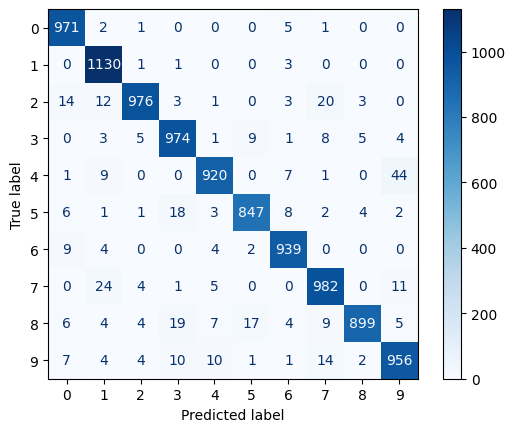

In [ ]:
conf_matr(y_test, y_pred, labels=knn.classes_)

# Set up for device agnostic code

In [ ]:
# Make device agostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Convert to tensors with dtype float32
X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test).to(device)

# Multi-layer Perceptron (MLP)
## What is a Multi-Layer Perceptron (MLP)?
A Multi-Layer Perceptron (MLP) is a type of artificial neural network (ANN) designed for supervised learning tasks like classification and regression. It is composed of:

1. Input Layer: Receives the features of the data.
2. Hidden Layers: Performs complex computations to detect patterns in the data.
3. Output Layer: Produces the final prediction or output.  
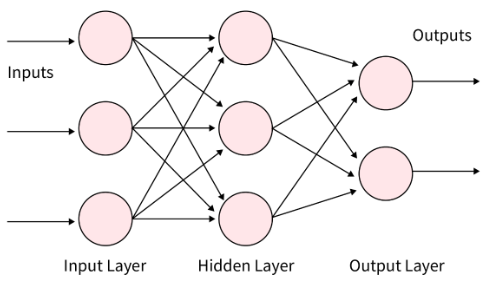

MLPs are fully connected networks, meaning each node in one layer is connected to every node in the next layer.

## How does it work?
1. Input :  
The input layer receives the input data with multiple features/attributes, represented as a vector $x$
2. Weights and Biases:  
Each connection between neurons has a weight $w$ and a bias $b$, which are continuously adjusted during training.  
3. Activation Function:  
Each neuron applies an activation function to introduce non-linearity. Common activation functions include:  
 - ReLU : $f(x)=max⁡(0,x)$
 - Sigmoid : $f(x) = \frac{1}{1 + e^{-x}}$  
 - Tanh : $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$  
4. Forward Pass:  
Input data propagates through the layers where
for each neuron, the output is given by :  
$\hat{y} = f(z)$  
where :  
$z=w⋅x+b$  

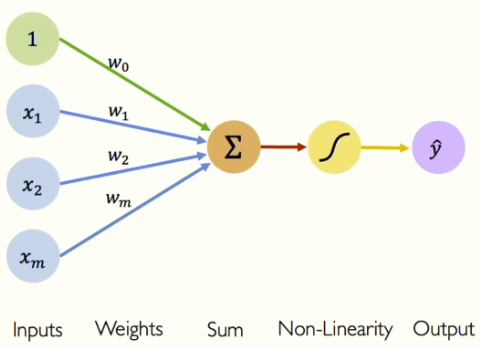
5. Loss Function:  
Measures the error between predicted and true values. Common loss functions:  
 - Mean Squared Error (MSE) for regression.
 - Cross-Entropy Loss for classification.
6. Optimization:  
Weights and biases are updated using algorithms like Stochastic Gradient Descent (SGD) or Adam.
7. Backpropagation :  
The optimization algorithms take gradients of the loss function as input. Backpropagation compute the gradient with respect to each weights and biases using chain rule.

In [ ]:
def stop_train(patience, patience_param, acc_now, acc_before):
  if patience == 0:
    return True, patience, acc_before
  else:
    if acc_before >= acc_now:
      patience -= 1
    else:
      patience = patience_param
    acc_before = acc_now
    return False, patience, acc_before

In [ ]:
def get_best_model(acc_now, epoch_now, model, best_acc, best_param, best_epoch):
  if acc_now > best_acc:
    best_acc = acc_now
    best_param = copy.deepcopy(model.state_dict())
    best_epoch = epoch_now
    print(f'Updates the best model, with test accuracy of {best_acc} at epoch {best_epoch}!')
  return best_acc, best_param, best_epoch

In [ ]:
def weight_init(m):
  if isinstance(m, (nn.Conv2d, nn.Linear)):
    with torch.no_grad():
      torch.nn.init.xavier_uniform_(m.weight)

In [ ]:
class simple_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=784*2)
    self.layer2 = nn.Linear(in_features=784*2, out_features=784)
    self.layer3 = nn.Linear(in_features=784, out_features=10)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.layer3(x)
    return x
nn_model = simple_nn().to(device)

In [ ]:
# Hyperparameter
epochs = 100
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(nn_model.parameters())

In [ ]:
start_time = time.time()
# Training loop
train_loss = []
test_loss_list = []
epoch_list = []
acc_train = []
acc_test = []
for epoch in range(epochs) :
  nn_model.train()
  logits = nn_model(X_train)
  y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
  acc = accuracy_score(y_train.to('cpu'), y_pred.to('cpu'))*100
  loss = loss_fn(logits, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  nn_model.eval()
  with torch.inference_mode():
    logits_test = nn_model(X_test)
    test_pred = torch.softmax(logits_test, dim=1).argmax(dim=1)
    test_acc = accuracy_score(y_train.to('cpu'), y_pred.to('cpu'))*100
    test_loss = loss_fn(logits_test, y_test)

  if epoch % 10 == 0 :
    print(f'Epoch : {epoch} Loss : {loss:.5f} Acc : {acc:.2f}% | Test Loss :{test_loss} Test acc : {test_acc:.2f}%' )
    epoch_list.append(epoch)
    train_loss.append(loss)
    test_loss_list.append(test_loss)
    acc_train.append(acc)
    acc_test.append(test_acc)

end_time = time.time()
nn_time = end_time - start_time

Epoch : 0 Loss : 2.30050 Acc : 9.48% | Test Loss :2.105102300643921 Test acc : 9.48%
Epoch : 10 Loss : 0.42842 Acc : 87.18% | Test Loss :0.4146069884300232 Test acc : 87.18%
Epoch : 20 Loss : 0.30465 Acc : 91.39% | Test Loss :0.32201528549194336 Test acc : 91.39%
Epoch : 30 Loss : 0.23258 Acc : 93.15% | Test Loss :0.26125219464302063 Test acc : 93.15%
Epoch : 40 Loss : 0.18238 Acc : 94.90% | Test Loss :0.21877287328243256 Test acc : 94.90%
Epoch : 50 Loss : 0.14396 Acc : 96.05% | Test Loss :0.1890432983636856 Test acc : 96.05%
Epoch : 60 Loss : 0.11219 Acc : 97.12% | Test Loss :0.16649913787841797 Test acc : 97.12%
Epoch : 70 Loss : 0.08627 Acc : 97.86% | Test Loss :0.15001559257507324 Test acc : 97.86%
Epoch : 80 Loss : 0.06489 Acc : 98.43% | Test Loss :0.13808216154575348 Test acc : 98.43%
Epoch : 90 Loss : 0.04780 Acc : 98.98% | Test Loss :0.129439577460289 Test acc : 98.98%


In [ ]:
nn_time

661.3098928928375

In [ ]:
logits = nn_model(X_test)
y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
print("Classification Report:\n", classification_report(y_test.to('cpu'), y_pred.to('cpu')))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.95      0.97      0.96       958
           7       0.97      0.97      0.97      1027
           8       0.96      0.94      0.95       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96      9999
   macro avg       0.96      0.96      0.96      9999
weighted avg       0.96      0.96      0.96      9999



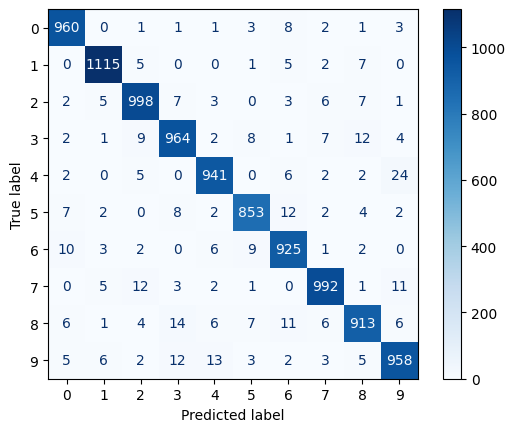

In [ ]:
conf_matr(y_test.to('cpu'),y_pred.to('cpu'),[0,1,2,3,4,5,6,7,8,9])

# Convolutional Neural Network (CNN)
## What is a Convolutional Neural Network (CNN)?
A Convolutional Neural Network (CNN) is a type of neural network designed for image data. CNNs take advantage of the spatial structure of data by applying filters to extract meaningful patterns such as edges, textures, and objects.
## How Does a CNN Work?
CNNs are made up of several key layers:
1. Convolutional Layer  
The convolutional layer applies filters (kernels) to the input image to create feature maps. A filter is a matrix which consist of learnable weights  $w_{ij}$. These filters slide over the image, performing a mathematical operation called convolution.

- For one position (p,q) of the feature map, its value is computed by:   
$\sum_{i=1}^{n} \sum_{j=1}^{m} w_{ij} x_{i+p, j+q} + b$  
where :  
 - $m$ : Width of the filter  
 - $n$ : Height of the filter  
 - $w_{ij}$ : A learnable weight in the filter at position $(i,j)$  
 - $x_{i+p, j+q}$ : The image input value at position $(i+p,j+q)$

A convolution operation example :  
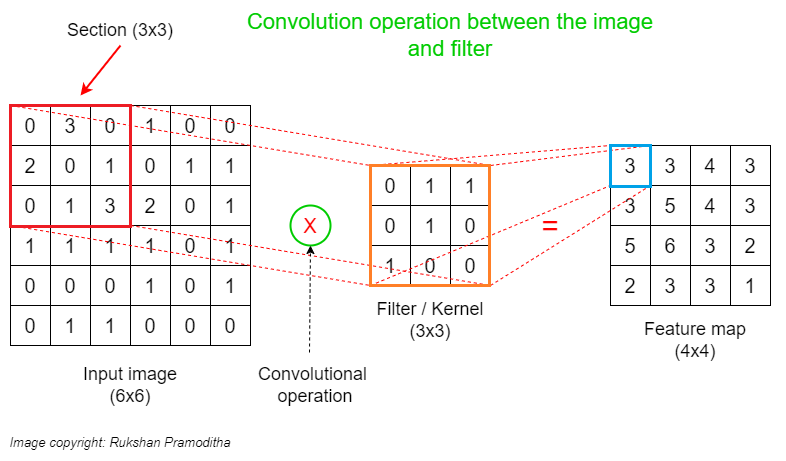  
2. Activation Function  
Non-linear activation functions (e.g., ReLU) are applied to the feature maps to introduce non-linearity.  
$f(x)=max(0,x)$  

3. Pooling Layer  
Pooling reduces the spatial dimensions of feature maps, making the network computationally efficient and less prone to overfitting. Common pooling methods:

 - Max Pooling: Takes the maximum value in a region.
 - Average Pooling: Takes the average value in a region.  
Example of Max Pooling and Average Pooling operation:  
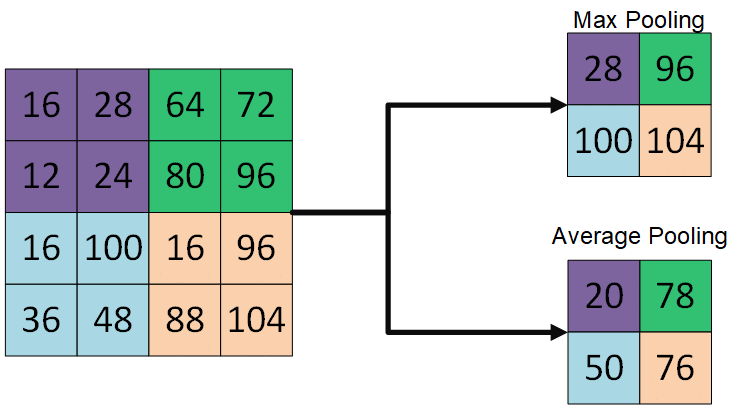

4. Fully Connected Layer  
After several convolutional and pooling layers, the output is flattened.
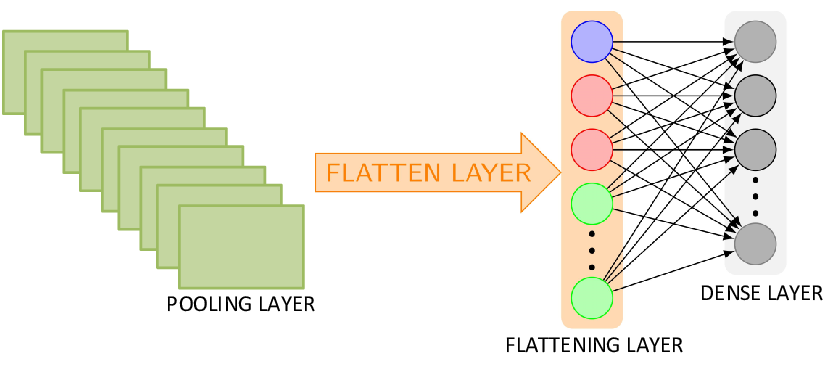  
The flattened layer could then be connected to layer of neurons or a fully connected layer for classification or regression.


In [ ]:
X_train_cnn = X_train.reshape(-1,1,28,28)
X_test_cnn = X_test.reshape(-1,1,28,28)
train_dataset = TensorDataset(X_train_cnn, y_train)
test_dataset = TensorDataset(X_test_cnn, y_test)

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False)
print(f'Number of batches\nTrain : {len(train_dataloader)}\nTest : {len(test_dataloader)}')
print(f'\nCheck data size\nTrain data :{next(iter(train_dataloader))[0].shape}\nlabels :{next(iter(train_dataloader))[1].shape}')

Number of batches
Train : 625
Test : 313

Check data size
Train data :torch.Size([32, 1, 28, 28])
labels :torch.Size([32])


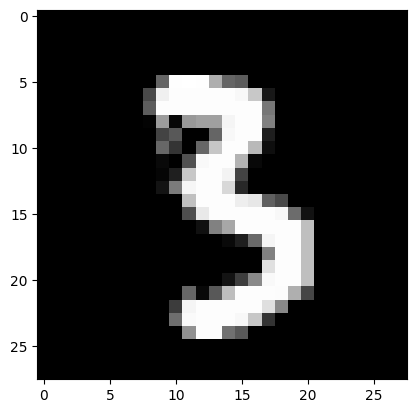

In [ ]:
# check image data
train_img = next(iter(train_dataloader))[0][0].to('cpu')
plt.imshow(train_img.squeeze(), cmap='gray')

In [ ]:
class CNN(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*14*14, out_features=output_shape)
    )

  def forward(self, x):
    return self.layers(x)

cnn_model = CNN(input_shape=1,hidden_units=16,output_shape=10).to(device)

In [ ]:
# Hyperparameter
epochs = 100
patience_param = 3
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(cnn_model.parameters())
# Initial values
patience = patience_param
acc_before = 0
best_acc = 0
best_epoch = 0
best_param = 0

In [ ]:
# Reset weight if needed to retrain the model
cnn_model.apply(weight_init)

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=3136, out_features=10, bias=True)
  )
)

In [ ]:
start_time = time.time()
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n-------')
  # Train
  train_loss, train_acc = 0, 0
  cnn_model.train()
  for X, y in train_dataloader:
    y_pred = cnn_model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_score(y.to('cpu'),
                                y_pred.argmax(dim=1).to('cpu'))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # Calculate loss and accuracy per epoch
  train_loss /= len(train_dataloader)
  train_acc = (train_acc/len(train_dataloader)) * 100
  print(f'Train loss :{train_loss:.5f} Train acc : {train_acc:.2f}%')

  # Test
  test_loss, test_acc = 0, 0
  cnn_model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = cnn_model(X)
      testing_loss = loss_fn(test_pred, y)
      test_loss += testing_loss
      test_acc += accuracy_score(y.to('cpu'),
                                test_pred.argmax(dim=1).to('cpu'))
    # Calculate loss and accuracy per epoch
    test_loss /= len(test_dataloader)
    test_acc = (test_acc/len(test_dataloader)) * 100
    print(f'Test loss :{test_loss:.5f} Test acc : {test_acc:.2f}% Patience : {patience}')

    # Updates the best model
    best_acc, best_param, best_epoch = get_best_model(test_acc, epoch, cnn_model, best_acc, best_param, best_epoch)

    # if test_acc declines, and patience run out, stop training
    stop_train_now, patience, acc_before = stop_train(patience, patience_param, test_acc, acc_before)
    if stop_train_now :
      print(f'Test accuracy went down.\nstopping training at epoch {epoch} with test acuracy of {test_acc}')
      break
end_time = time.time()
cnn_time = end_time - start_time

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss :0.36123 Train acc : 89.13%
Test loss :0.15919 Test acc : 95.22% Patience : 3
Updates the best model, with test accuracy of 95.2176517571885 at epoch 0!
Epoch: 1
-------
Train loss :0.10702 Train acc : 96.86%
Test loss :0.08296 Test acc : 97.32% Patience : 3
Updates the best model, with test accuracy of 97.32428115015975 at epoch 1!
Epoch: 2
-------
Train loss :0.07238 Train acc : 97.71%
Test loss :0.07249 Test acc : 97.56% Patience : 3
Updates the best model, with test accuracy of 97.56389776357828 at epoch 2!
Epoch: 3
-------
Train loss :0.05230 Train acc : 98.37%
Test loss :0.06340 Test acc : 97.96% Patience : 3
Updates the best model, with test accuracy of 97.9632587859425 at epoch 3!
Epoch: 4
-------
Train loss :0.04064 Train acc : 98.67%
Test loss :0.07347 Test acc : 97.51% Patience : 3
Epoch: 5
-------
Train loss :0.03409 Train acc : 98.94%
Test loss :0.06247 Test acc : 98.04% Patience : 2
Updates the best model, with test accuracy of 98.0431309904153

In [ ]:
cnn_time

718.7441210746765

In [ ]:
# Load the best model
cnn_model.load_state_dict(best_param)

<All keys matched successfully>

Accuracy : 0.9836983698369837
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.98      0.98      1027
           8       0.99      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98      9999
   macro avg       0.98      0.98      0.98      9999
weighted avg       0.98      0.98      0.98      9999



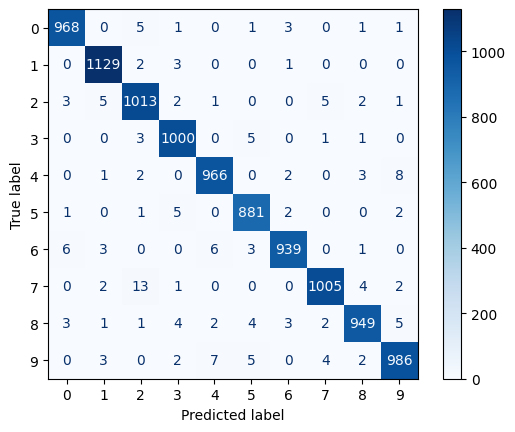

In [ ]:
# Test the best model
cnn_model.eval()
with torch.inference_mode():
  y_pred = cnn_model(X_test_cnn)
  test_acc = accuracy_score(y_test.to('cpu'),
                              y_pred.argmax(dim=1).to('cpu'))
# classification report
print(f'Accuracy : {test_acc}')
print("Classification Report:\n", classification_report(y_test.to('cpu'), y_pred.argmax(dim=1).to('cpu')))

# confusion matrix
conf_matr(y_test.to('cpu'),y_pred.argmax(dim=1).to('cpu'),[0,1,2,3,4,5,6,7,8,9])

In [ ]:
# Save model to drive
path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer(MNIST)/model/'
model_name = f'digit_recognizer_acc_{test_acc}.pth'
model_path = path + model_name
torch.save(cnn_model.state_dict(),model_path)

# Result Summary
| Model     | Test Accuracy | Time(s) |
|------------|-----------|--------|
| Support Vector Machines(SVM)| 0.97   | 50.75   |
| K-nearest neighboor (KNN)    | 0.96      | **0.10**   |
| Multi-layer Perceptron (MLP)    | 0.96      | 661.30   |
| Convolutional Neural Network (CNN)   |**0.98**      | 718.74   |

The CNN model has achieved the highest accuracy (0.98) among the models.

# Will it generalize to the real-world handwritten digits?
The Convolutional Neural Network (CNN), which achieved the highest accuracy (0.98), will be used to predict newly photographed handwritten digits. This evaluation will test the robustness of the MNIST dataset and the trained CNN model against variations in handwriting styles, such as:
* Thick lines
* Skewed positioning
* Thin lines

In [ ]:
folders = [Path('/content/drive/MyDrive/Colab Notebooks/Digit Recognizer(MNIST)/normal'),Path('/content/drive/MyDrive/Colab Notebooks/Digit Recognizer(MNIST)/diff_pos'),Path('/content/drive/MyDrive/Colab Notebooks/Digit Recognizer(MNIST)/thin')]
img_list = []
for folder in folders:
  files = folder.glob('*')
  for file in files:
    img = cv2.imread(str(file))
    # Resize to fit the input layer
    img = cv2.resize(img, (28,28), interpolation=cv2.INTER_AREA)
    img_list.append(img)
img_np = np.array(img_list)
print(f'img_np shape : {img_np.shape}')

img_np shape : (15, 28, 28, 3)


Display the original images

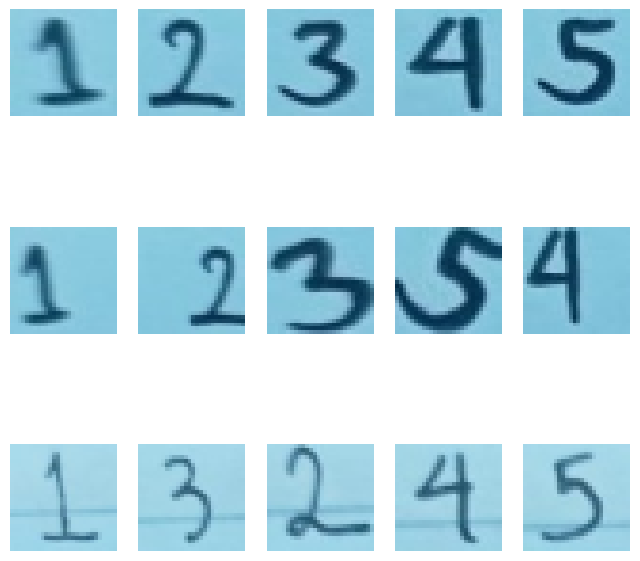

In [ ]:
row = 3
col = 5
fig, axes = plt.subplots(row,col,figsize=(8,8))
axes = axes.flatten()
for i in range(row*col):
  image = img_np[i]
  axes[i].imshow(image)
  axes[i].axis('off')

In [ ]:
# Preprocess the images to resemble mnist-style images, making it easier for the model to recognize
imgs = []
for img in img_np :
  # Convert images to grayscale
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Apply threshold to conver the image to (inverse) black and white
  (thresh, bw_img) = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  imgs.append(bw_img)
imgs_processed = np.array(imgs)

Display the preprocessed images

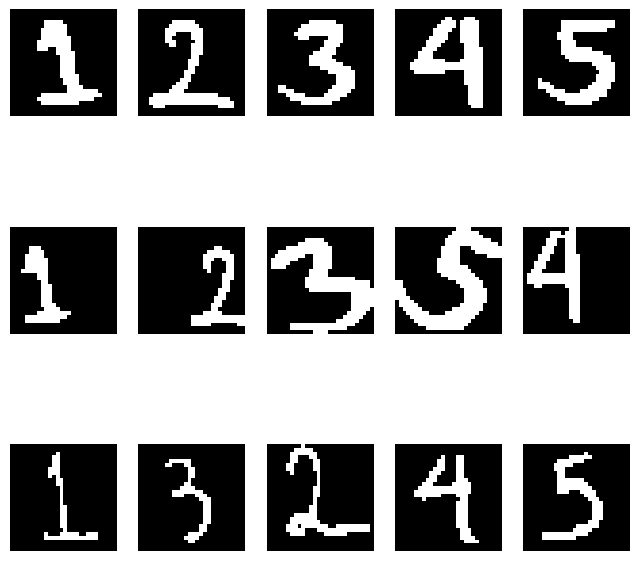

In [ ]:
row = 3
col = 5
fig, axes = plt.subplots(row,col,figsize=(8,8))
axes = axes.flatten()
for i in range(row*col):
  image = imgs_processed[i]
  axes[i].imshow(image, cmap='gray')
  axes[i].axis('off')

In [ ]:
# Normalize
imgs_processed = imgs_processed / 255.0
# Reshape
imgs_test = np.expand_dims(imgs_processed, axis=1)

In [ ]:
# Convert to tensor, move to device
imgs_test = torch.from_numpy(imgs_test.astype(np.float32)).to(device)

In [ ]:
# Predict the samples
cnn_model.eval()
with torch.inference_mode():
  y_pred = cnn_model(imgs_test).argmax(dim=1)

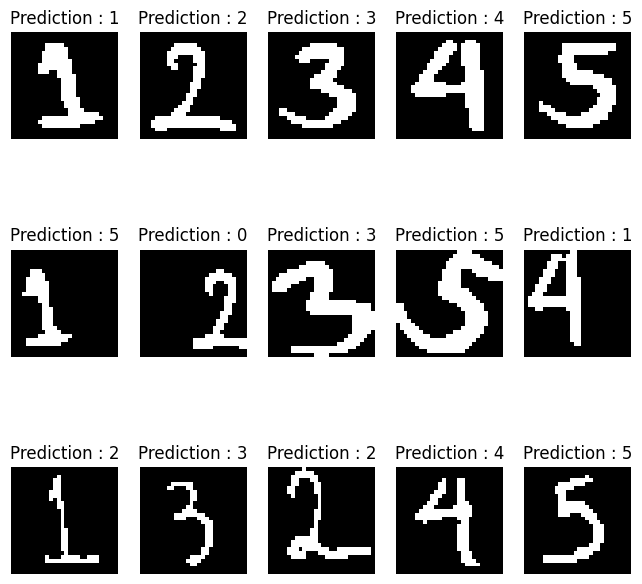

In [ ]:
row = 3
col = 5
imgs_test = np.squeeze(imgs_test).to('cpu')
fig, axes = plt.subplots(row,col,figsize=(8,8))
axes = axes.flatten()
for i in range(row*col):
  image = imgs_test[i]
  title = y_pred[i]
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f'Prediction : {title}')
  axes[i].axis('off')

*   The handwritten digits with the thick lines were predicted perfectly due to their similarity to the MNIST dataset.
*   The handwritten digits with skewed positioning received wrong predictions except for the digit 3 and 5. This suggests that the majority of the MNIST dataset are aligned in the center. As a result, the CNN feature maps struggle to recognize image features when the positioning is skewed.  
  - The digit 3 and 5 are aligned in the center but are rotated. It seems that the MNIST dataset and the CNN model are more robust to rotation than translation of the digits.
* The handwritten digits with the thin lines received correct predictions, except for the digit 1. It could be that for the thin-lined digits in the MNIST dataset, digit 1 writtings resemble one stroke of line only, while this new thin-lined digit contains 3 strokes that makes it resemble digit 2.




# Conclusion

| Model     | Test Accuracy | Time(s) |
|------------|-----------|--------|
| Support Vector Machines(SVM)| 0.97   | 50.75   |
| K-nearest neighboor (KNN)    | 0.96      | **0.10**   |
| Multi-layer Perceptron (MLP)    | 0.96      | 661.30   |
| Convolutional Neural Network (CNN)   |**0.98**      | 718.74   |

* CNN gives the best accuracy even though it is the slowest to train, taking 718.74 seconds. This model is suitable when high accuracy is prioritized and longer training time is acceptable.
* KNN has the fastest time to train/create a model ready for prediction(0.10 seconds) but achieves slightly lower accuracy (0.96). This makes it ideal for scenarios where training time is important, and a slight trade-off in accuracy is acceptable.
* SVM achieves high accuracy (0.97) with a much shorter training time (50.75 seconds) compared to CNN. This model gives good compromise between accuracy and training time.
* CNN model with the highest testing accuracy struggles to predict digits with skewed positioning (translation) and thin-lined digit 1.


# To do next
We could make the CNN model more robust and potentially achieve higher accuracy by :  


*   Data Augmentation  
    Handwritten digits retrieved from various sources in the real world may have skewed positions, various stroke widths or even distortions in the image. We could help our model generalize better to these images by applying distortion, translation and filters to the existing MNIST dataset and add them in our training dataset.
*   Hyperparameter Seach  
    Different choices of hyperparameters such as batch size, kernel size, learning rate,etc., could make a significant impact on the model's performance. We could explore the hyperparameter space using hyperparameter optimization algorithms such as grid search, random search, or Bayesian optimization to find the best configuration.
*   Model Architecture Exploration  
    Exploring alternative CNN architectures, such as deeper networks, residual connections, or attention mechanisms, might improve accuracy.

